In [1]:
# Import necessary libraries
import pandas as pd

# Load dataset
file_path = r'C:\Users\ahmed\Downloads\train.csv'
data = pd.read_csv(file_path)

# Sample the dataset to reduce size (20% of data for speed)
data_sample = data.sample(frac=0.2, random_state=42)

# Drop irrelevant columns (if any)
irrelevant_columns = ['physical_part_id', 'message_timestamp']  # Adjust based on domain knowledge
data_sample = data_sample.drop(columns=[col for col in irrelevant_columns if col in data_sample.columns])

# Preview the sampled data
print(f"Sampled dataset shape: {data_sample.shape}")
print(data_sample.head())
print(data_sample.info())


Sampled dataset shape: (8964, 374)
      physical_part_type  weekday         shift status  \
24536              type2   Monday  Nachtschicht     OK   
842                type2   Monday  Spaetschicht     OK   
18600              type1  Tuesday  Fruehschicht     OK   
16403              type1   Friday  Nachtschicht     OK   
25303              type1   Monday  Nachtschicht     OK   

       s6_sensor0_millimeter_step1  s8_sensor0_millimeter_step1  \
24536                  5886.043819                    18.977389   
842                    5886.043819                    19.304810   
18600                  4606.469076                    18.972192   
16403                  4606.469076                    17.659912   
25303                  4606.469076                    22.056700   

       s8_sensor1_millimeter_step1  s7_sensor0_newton_step1  \
24536                   385.890552              8865.426335   
842                     393.970153              8854.226959   
18600                   

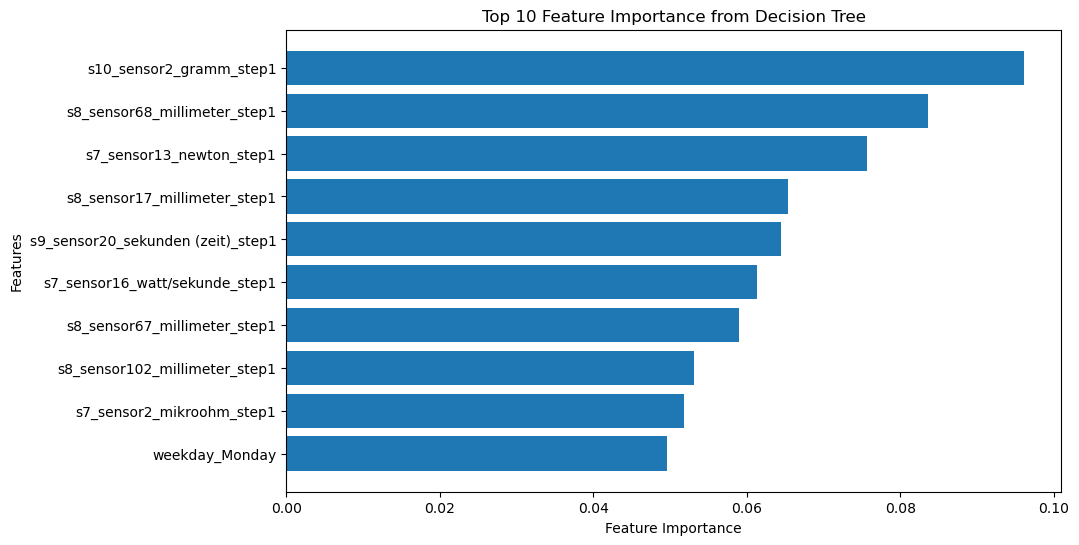

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Separate features and target
X = data_sample.drop(columns=['status'])
y = data_sample['status']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Ensure no duplicate columns after encoding
X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
tree = DecisionTreeClassifier(random_state=42, max_depth=5)  # Limiting depth for efficiency
tree.fit(X_train, y_train)

# Feature importance
importances = tree.feature_importances_
features = X_encoded.columns
top_indices = importances.argsort()[::-1][:10]  # Top 10 features

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features[top_indices][::-1], importances[top_indices][::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance from Decision Tree')
plt.show()


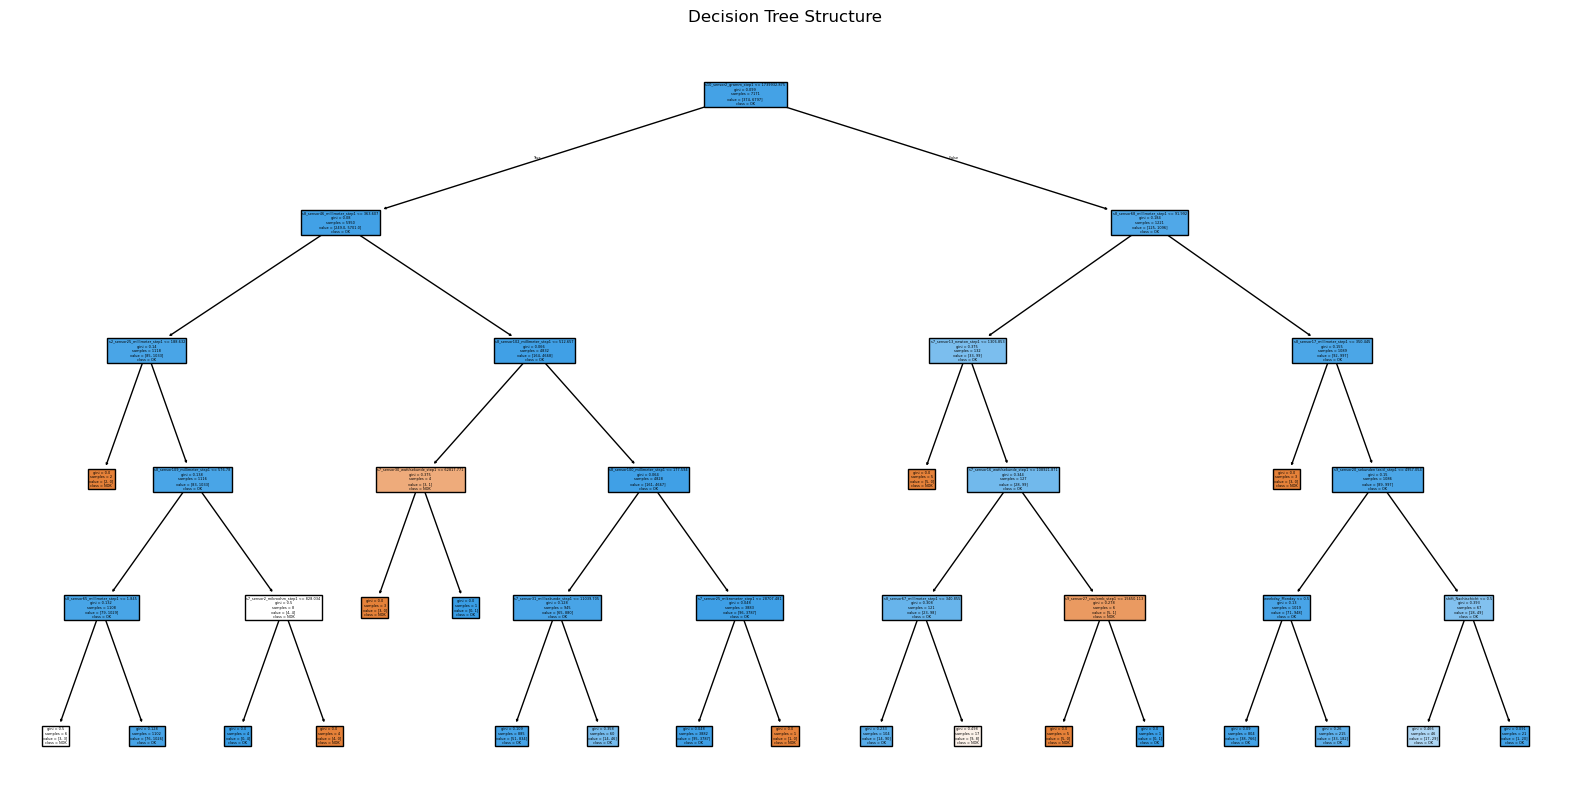

In [3]:
from sklearn.tree import plot_tree

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, class_names=tree.classes_, filled=True)
plt.title("Decision Tree Structure")
plt.show()


In [4]:
from sklearn.tree import export_text

# Export and print decision rules
rules = export_text(tree, feature_names=list(features))
print("Decision Rules:\n")
print(rules)


Decision Rules:

|--- s10_sensor2_gramm_step1 <= 1739932.88
|   |--- s8_sensor46_millimeter_step1 <= 363.61
|   |   |--- s2_sensor25_millimeter_step1 <= 188.63
|   |   |   |--- class: NOK
|   |   |--- s2_sensor25_millimeter_step1 >  188.63
|   |   |   |--- s8_sensor109_millimeter_step1 <= 576.78
|   |   |   |   |--- s8_sensor65_millimeter_step1 <= 1.85
|   |   |   |   |   |--- class: NOK
|   |   |   |   |--- s8_sensor65_millimeter_step1 >  1.85
|   |   |   |   |   |--- class: OK
|   |   |   |--- s8_sensor109_millimeter_step1 >  576.78
|   |   |   |   |--- s7_sensor2_mikroohm_step1 <= 828.03
|   |   |   |   |   |--- class: OK
|   |   |   |   |--- s7_sensor2_mikroohm_step1 >  828.03
|   |   |   |   |   |--- class: NOK
|   |--- s8_sensor46_millimeter_step1 >  363.61
|   |   |--- s8_sensor102_millimeter_step1 <= 512.66
|   |   |   |--- s7_sensor30_watt/sekunde_step1 <= 62817.77
|   |   |   |   |--- class: NOK
|   |   |   |--- s7_sensor30_watt/sekunde_step1 >  62817.77
|   |   |   |   |--- 

In [9]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Example DataFrame (X_encoded) loaded
# Ensure X_encoded is your feature DataFrame

# Step 1: Handle All-NaN Columns
# Identify columns with all NaN values
all_nan_cols = X_encoded.columns[X_encoded.isnull().all()]
print("Columns with all NaN values:", list(all_nan_cols))

# Option 1: Drop all-NaN columns
X_encoded_cleaned = X_encoded.drop(columns=all_nan_cols)

# Option 2: Fill all-NaN columns with a default value (e.g., 0)
# Uncomment the following line if you prefer this approach:
# X_encoded[all_nan_cols] = 0

# Step 2: Impute Remaining Columns
# Select numeric columns only
numeric_cols = X_encoded_cleaned.select_dtypes(include=['float', 'int']).columns

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Impute numeric columns
X_imputed_array = imputer.fit_transform(X_encoded_cleaned[numeric_cols])

# Convert back to DataFrame with correct column names and index
X_imputed = pd.DataFrame(X_imputed_array, columns=numeric_cols, index=X_encoded_cleaned.index)

# Step 3: Reintroduce All-NaN Columns (if filled with a constant earlier)
# Uncomment this line if you chose to fill all-NaN columns with a constant
# X_imputed = pd.concat([X_imputed, X_encoded[all_nan_cols]], axis=1)

# Step 4: Verify Shape and Missing Values
print("Shape after imputation:", X_imputed.shape)
print("Remaining missing values:", X_imputed.isnull().sum().sum())


Columns with all NaN values: ['s2_sensor4_millimeter_step1', 's2_sensor5_millimeter_step1', 's2_sensor8_millimeter_step1', 's3_sensor1_meter_step1', 's2_sensor16_millimeter_step1']
Shape after imputation: (8964, 365)
Remaining missing values: 0


In [14]:
from sklearn.tree import DecisionTreeClassifier

# Step 1: Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)  # Train on X_train

# Step 2: Debug Feature Names
trained_features = clf.feature_names_in_  # Features used during training
current_features = X.columns

missing_features = set(trained_features) - set(current_features)
extra_features = set(current_features) - set(trained_features)

print("Missing features:", missing_features)
print("Extra features:", extra_features)

# Step 3: Fix Missing Features
for col in missing_features:
    X[col] = 0  # Add missing features with a default value

# Step 4: Fix Extra Features
X = X.drop(columns=list(extra_features))

# Step 5: Align Column Order
X = X[trained_features]

# Step 6: Apply the Model to Compute Leaf Nodes
leaf_nodes = clf.apply(X)

# Step 7: Add Leaf Node Column to the Dataset
data_sample['leaf_node'] = leaf_nodes

# Step 8: Group by Leaf Nodes and Compute Summary
numeric_columns = data_sample.select_dtypes(include=['number']).columns
leaf_summary = data_sample.groupby('leaf_node')[numeric_columns].mean()

# Display the Leaf Node Summary
print("Leaf Node Summary:")
print(leaf_summary.head())



Missing features: {'shift_Nachtschicht', 'physical_part_type_type2', 'weekday_Tuesday', 'weekday_Thursday', 'shift_Spaetschicht', 'weekday_Sunday', 'physical_part_type_type4', 'weekday_Wednesday', 'weekday_Monday'}
Extra features: {'physical_part_type', 'shift', 'weekday'}
Leaf Node Summary:
           s6_sensor0_millimeter_step1  s8_sensor0_millimeter_step1  \
leaf_node                                                             
3                          4606.469076                    18.443382   
7                          4926.362762                    20.506001   
8                          5246.256448                    21.383019   
12                         4606.469076                    19.769088   
13                         4606.469076                    18.985185   

           s8_sensor1_millimeter_step1  s7_sensor0_newton_step1  \
leaf_node                                                         
3                           344.554984              8887.825088   
7       

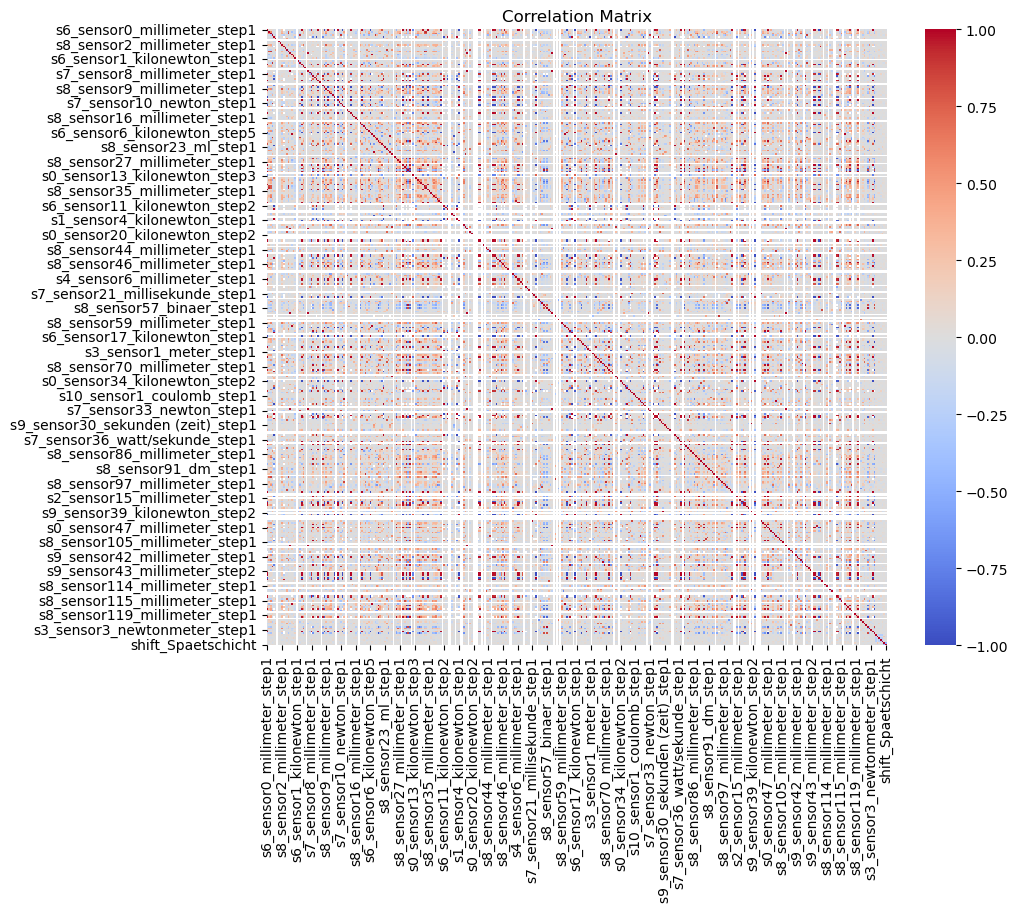

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


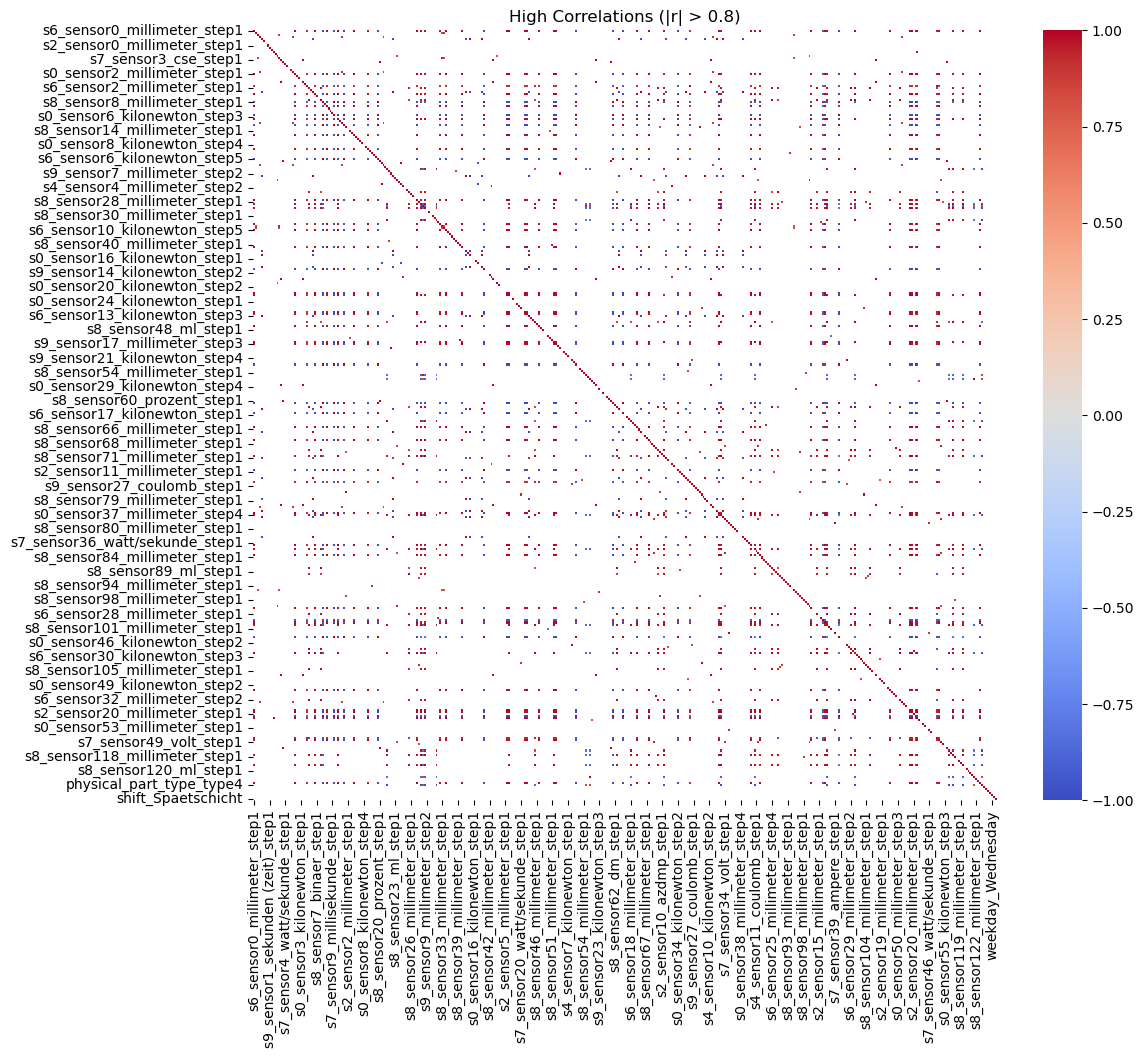

In [16]:
# Set a threshold for high correlation
correlation_threshold = 0.8

# Compute the correlation matrix
correlation_matrix = X_encoded.corr()

# Filter for high correlations
high_corr = correlation_matrix[(correlation_matrix > correlation_threshold) | (correlation_matrix < -correlation_threshold)]
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr, cmap='coolwarm', annot=False, mask=high_corr.isnull(), cbar=True)
plt.title("High Correlations (|r| > 0.8)")
plt.show()


In [17]:
# Flatten the correlation matrix and sort by correlation strength
corr_pairs = correlation_matrix.unstack()
sorted_corr_pairs = corr_pairs.sort_values(key=lambda x: abs(x), ascending=False)

# Select the top-N correlations (excluding self-correlations)
top_corr_pairs = sorted_corr_pairs[(sorted_corr_pairs != 1.0) & (sorted_corr_pairs.notnull())].head(10)
print("Top 10 Correlated Feature Pairs:\n", top_corr_pairs)


Top 10 Correlated Feature Pairs:
 s0_sensor9_kilonewton_step1   s6_sensor22_kilonewton_step2    1.0
s6_sensor22_kilonewton_step2  s0_sensor9_kilonewton_step1     1.0
s9_sensor3_kilonewton_step3   s6_sensor24_kilonewton_step3    1.0
s6_sensor24_kilonewton_step3  s9_sensor3_kilonewton_step3     1.0
s6_sensor10_kilonewton_step5  s0_sensor31_kilonewton_step2   -1.0
s0_sensor31_kilonewton_step2  s6_sensor10_kilonewton_step5   -1.0
s0_sensor39_millimeter_step2  s6_sensor0_millimeter_step1     1.0
s6_sensor19_kilonewton_step3  s6_sensor24_kilonewton_step3    1.0
s6_sensor0_millimeter_step1   s0_sensor39_millimeter_step2    1.0
s6_sensor24_kilonewton_step3  s6_sensor19_kilonewton_step3    1.0
dtype: float64


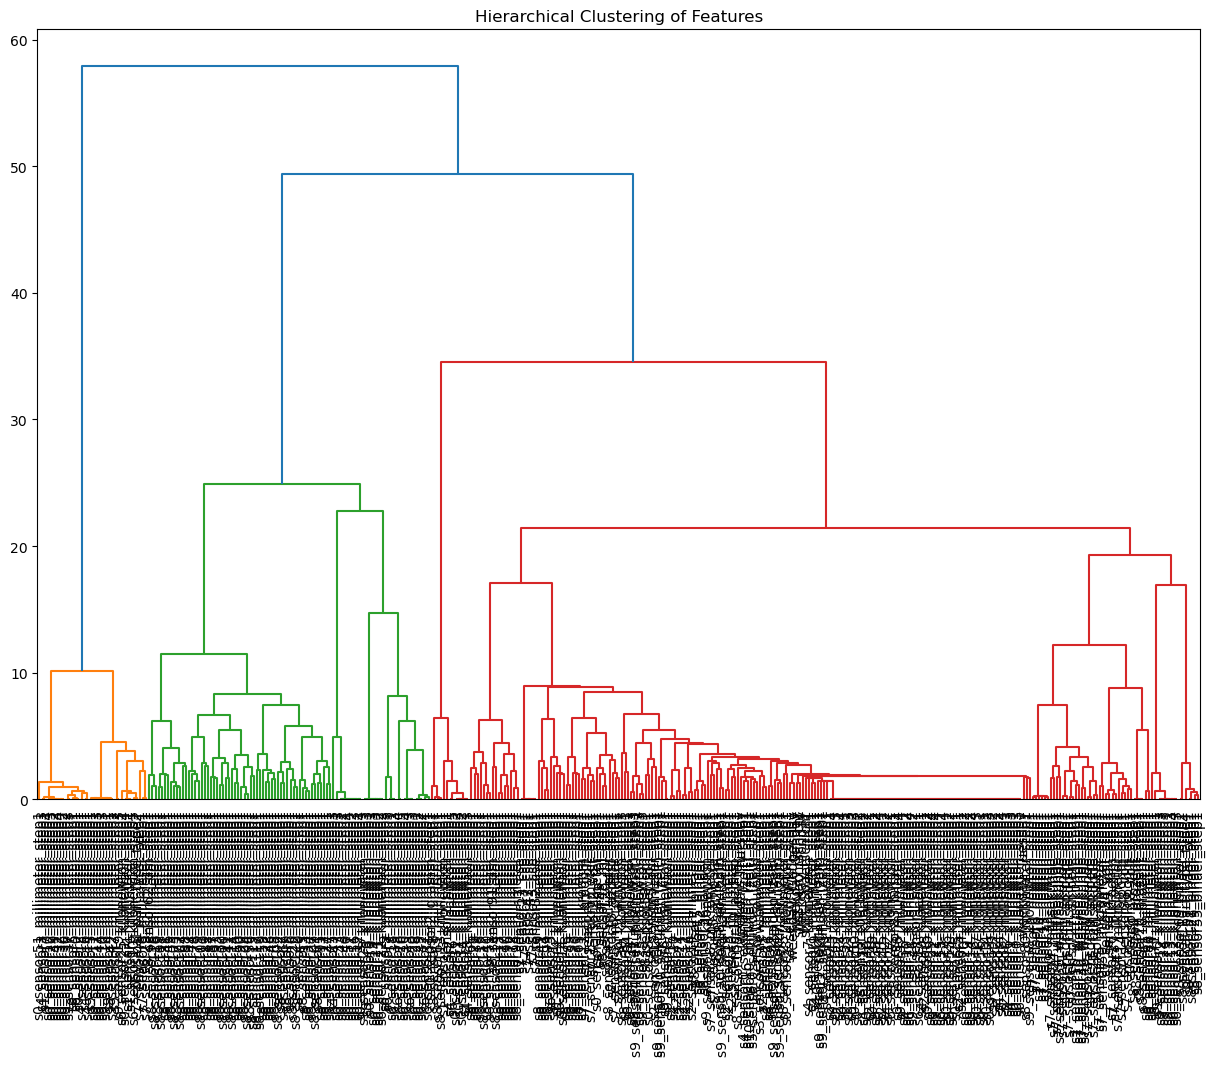

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

# Compute the correlation matrix
correlation_matrix = X_encoded.corr()

# Replace NaN values with 0 (or another neutral value)
correlation_matrix = correlation_matrix.fillna(0)

# Ensure all values are finite (no Inf or NaN)
if not np.all(np.isfinite(correlation_matrix)):
    print("Non-finite values found in correlation matrix!")
    correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)

# Perform hierarchical clustering on the correlation matrix
link = linkage(correlation_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(link, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering of Features")
plt.show()

C:\ProgramData\miniconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['s2_sensor4_millimeter_step1' 's2_sensor5_millimeter_step1'
 's2_sensor8_millimeter_step1' 's3_sensor1_meter_step1'
 's2_sensor16_millimeter_step1']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


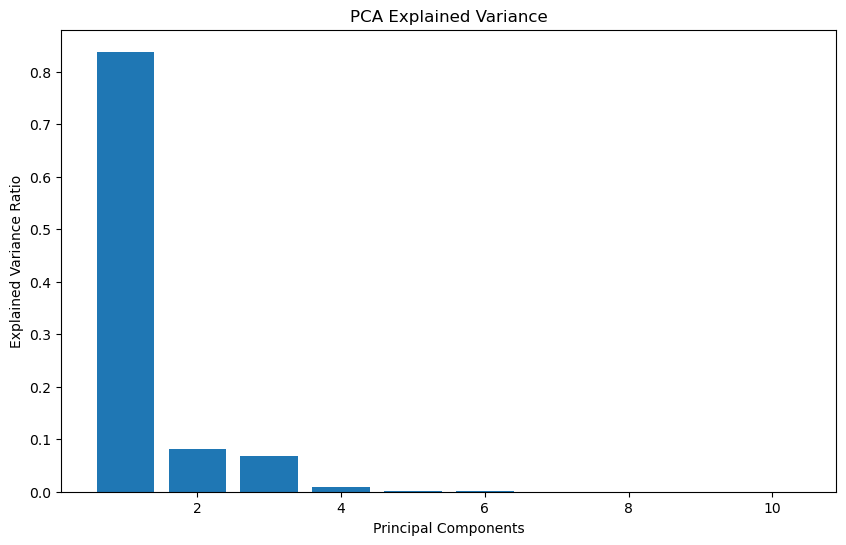

Cumulative Explained Variance: [0.83817137 0.92024486 0.9880564  0.99689763 0.99777656 0.99851084
 0.99887829 0.99914829 0.99937507 0.9995038 ]


In [19]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Step 1: Handle Missing Values (Impute)
imputer = SimpleImputer(strategy='mean')  # Use 'median' or other strategies if more suitable
X_imputed = imputer.fit_transform(X_encoded)  # Impute missing values

# Step 2: Apply PCA
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca_result = pca.fit_transform(X_imputed)

# Step 3: Plot Explained Variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

# Optional: Print cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

In [20]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Check for NaNs or zeros in the correlation matrix
print(correlation_matrix.isnull().sum().sum())  # Total NaNs
print((correlation_matrix == 0).sum().sum())   # Total zeros

# Preview the correlation matrix
print(correlation_matrix.head())


0
45499
                             s6_sensor0_millimeter_step1  \
s6_sensor0_millimeter_step1                     1.000000   
s8_sensor0_millimeter_step1                     0.040523   
s8_sensor1_millimeter_step1                     0.082342   
s7_sensor0_newton_step1                         0.026265   
s9_sensor0_kilonewton_step1                    -0.008661   

                             s8_sensor0_millimeter_step1  \
s6_sensor0_millimeter_step1                     0.040523   
s8_sensor0_millimeter_step1                     1.000000   
s8_sensor1_millimeter_step1                     0.590424   
s7_sensor0_newton_step1                        -0.116368   
s9_sensor0_kilonewton_step1                    -0.007974   

                             s8_sensor1_millimeter_step1  \
s6_sensor0_millimeter_step1                     0.082342   
s8_sensor0_millimeter_step1                     0.590424   
s8_sensor1_millimeter_step1                     1.000000   
s7_sensor0_newton_step1       

In [22]:
import pandas as pd
import numpy as np
import plotly.express as px

# Ensure correlation matrix is computed from a valid DataFrame (replace `X_encoded` with your feature DataFrame)
# Compute the correlation matrix
correlation_matrix = X_encoded.corr()

# Handle missing or infinite values in the correlation matrix
correlation_matrix = correlation_matrix.fillna(0)  # Replace NaNs with 0
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)  # Replace infinities with 0

# Select the top 7 features based on the sum of absolute correlations
top_features = correlation_matrix.abs().sum(axis=1).sort_values(ascending=False).head(7).index

# Extract the correlation matrix for the top 7 features
filtered_correlation_matrix = correlation_matrix.loc[top_features, top_features]

# Debugging: Ensure the filtered correlation matrix is non-empty
print("Filtered Correlation Matrix:")
print(filtered_correlation_matrix)

# Plot the interactive heatmap using Plotly
fig = px.imshow(filtered_correlation_matrix, 
                color_continuous_scale='Viridis', 
                title="Correlation Matrix of Top 7 Features")

# Update layout for better visualization
fig.update_layout(width=800, height=800)

# Show the figure
fig.show()



Filtered Correlation Matrix:
                              s0_sensor47_millimeter_step1  \
s0_sensor47_millimeter_step1                      1.000000   
s0_sensor33_millimeter_step3                      0.960616   
s0_sensor43_millimeter_step2                      0.960616   
s0_sensor57_millimeter_step4                      0.960616   
s0_sensor40_millimeter_step1                      0.960616   
s0_sensor12_millimeter_step1                      0.960616   
s0_sensor37_millimeter_step4                      0.960616   

                              s0_sensor33_millimeter_step3  \
s0_sensor47_millimeter_step1                      0.960616   
s0_sensor33_millimeter_step3                      1.000000   
s0_sensor43_millimeter_step2                      1.000000   
s0_sensor57_millimeter_step4                      1.000000   
s0_sensor40_millimeter_step1                      1.000000   
s0_sensor12_millimeter_step1                      1.000000   
s0_sensor37_millimeter_step4            

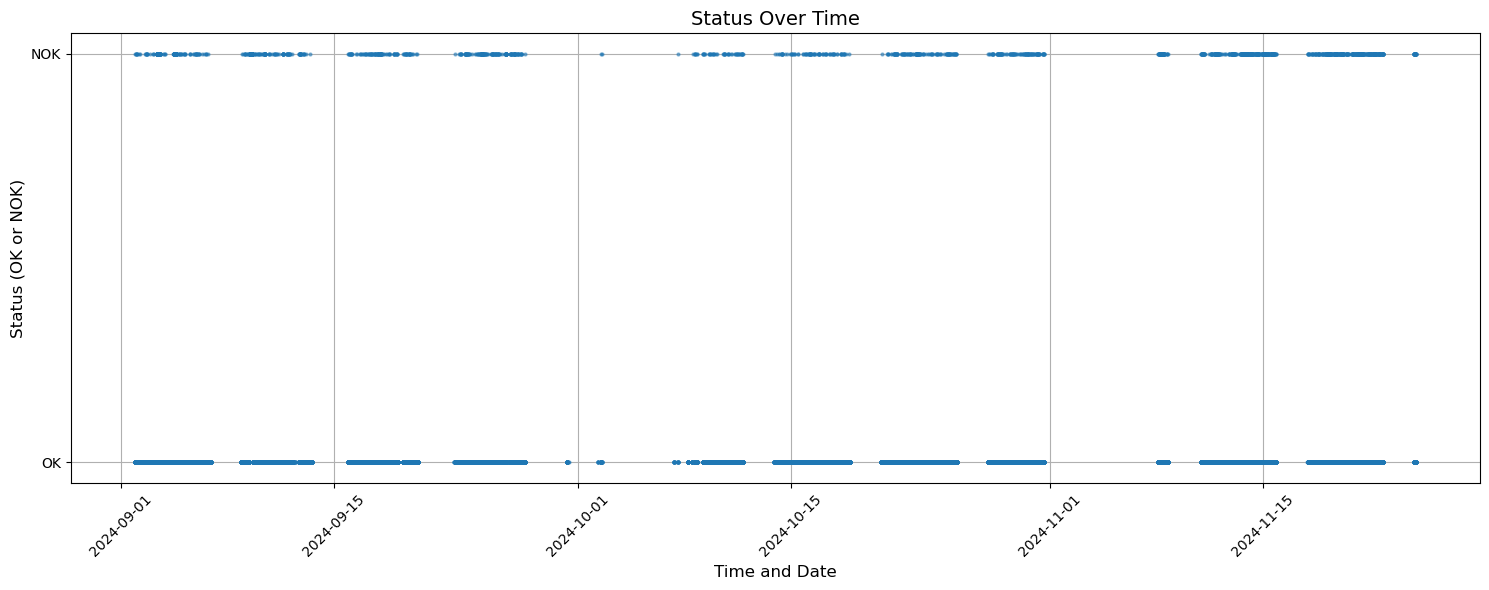

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'message_timestamp' is in datetime format
data['message_timestamp'] = pd.to_datetime(data['message_timestamp'])

# Sort the data by time for better plotting
data_sorted = data.sort_values(by='message_timestamp')

# Plot status over time
plt.figure(figsize=(15, 6))
plt.plot(data_sorted['message_timestamp'], data_sorted['status'], 'o', alpha=0.5, markersize=2)

# Formatting the plot
plt.xlabel("Time and Date", fontsize=12)
plt.ylabel("Status (OK or NOK)", fontsize=12)
plt.title("Status Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


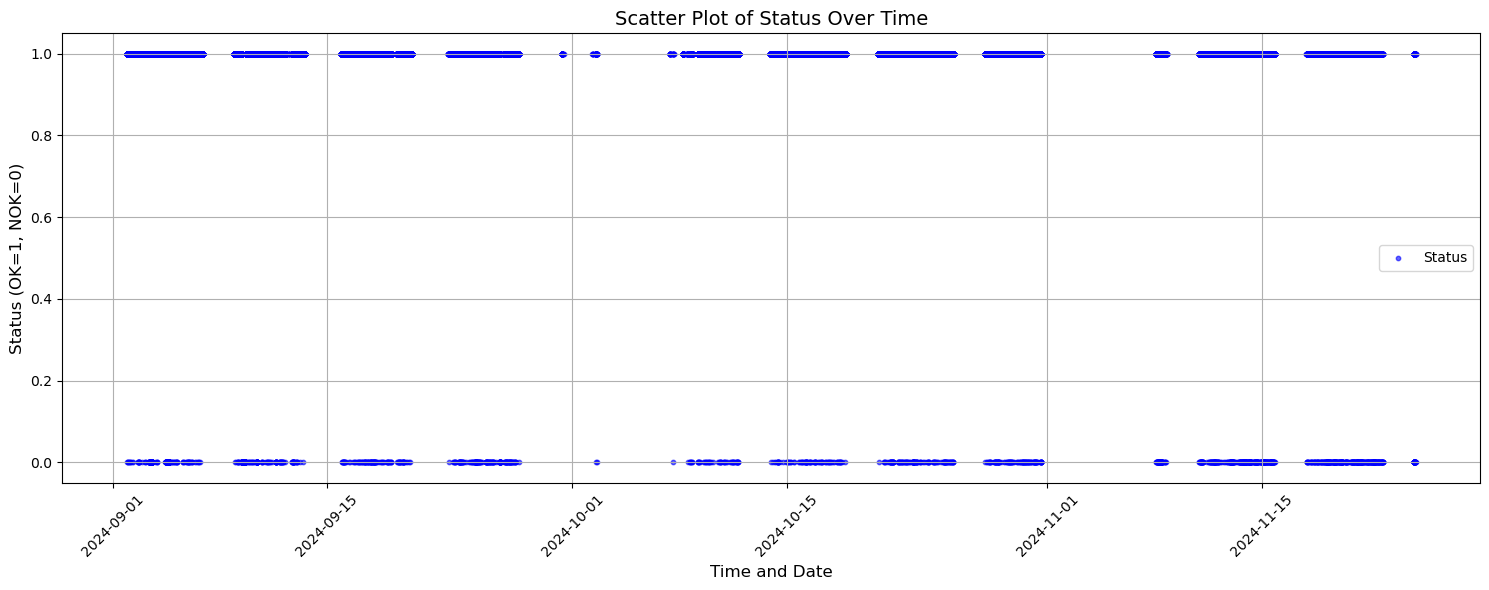

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'message_timestamp' is in datetime format
data['message_timestamp'] = pd.to_datetime(data['message_timestamp'])

# Sort the data by time for better plotting
data_sorted = data.sort_values(by='message_timestamp')

# Map 'OK' to 1 and 'NOK' to 0 for scatter plotting
data_sorted['status_encoded'] = data_sorted['status'].map({'OK': 1, 'NOK': 0})

# Create scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(data_sorted['message_timestamp'], data_sorted['status_encoded'], alpha=0.6, s=10, c='blue', label='Status')

# Formatting the plot
plt.xlabel("Time and Date", fontsize=12)
plt.ylabel("Status (OK=1, NOK=0)", fontsize=12)
plt.title("Scatter Plot of Status Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [29]:
# Calculate IQR and identify outliers for a single feature
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

# Apply to all features
outliers = {}
for feature in data_sample.select_dtypes(include=['float', 'int']).columns:
    outliers[feature] = detect_outliers_iqr(data_sample, feature)
    print(f"{feature} has {len(outliers[feature])} outliers.")


s6_sensor0_millimeter_step1 has 0 outliers.
s8_sensor0_millimeter_step1 has 18 outliers.
s8_sensor1_millimeter_step1 has 20 outliers.
s7_sensor0_newton_step1 has 25 outliers.
s9_sensor0_kilonewton_step1 has 1 outliers.
s7_sensor1_mikrometer_step1 has 425 outliers.
s0_sensor0_kilonewton_step3 has 0 outliers.
s2_sensor0_millimeter_step1 has 359 outliers.
s9_sensor1_sekunden (zeit)_step1 has 34 outliers.
s8_sensor2_millimeter_step1 has 302 outliers.
s0_sensor1_millimeter_step1 has 8 outliers.
s9_sensor2_sekunden (zeit)_step1 has 43 outliers.
s7_sensor2_mikroohm_step1 has 77 outliers.
s8_sensor3_millimeter_step1 has 15 outliers.
s7_sensor3_cse_step1 has 0 outliers.
s8_sensor4_prozent_step1 has 1525 outliers.
s7_sensor4_watt/sekunde_step1 has 330 outliers.
s8_sensor5_dm_step1 has 649 outliers.
s6_sensor1_kilonewton_step1 has 0 outliers.
s7_sensor5_mikrometer_step1 has 208 outliers.
s7_sensor6_newton_step1 has 4 outliers.
s0_sensor2_millimeter_step1 has 0 outliers.
s8_sensor6_millimeter_step